In [1]:
%config Completer.use_jedi = False

In [2]:
import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import sklearn.model_selection as skm

import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
air_bnb = pd.read_csv("./airbnb.csv")

dataset = air_bnb[['latitude', 'longitude', 'id']].to_numpy()

scaler = skp.StandardScaler()
scaler.fit(dataset)

dataset = scaler.transform(dataset)

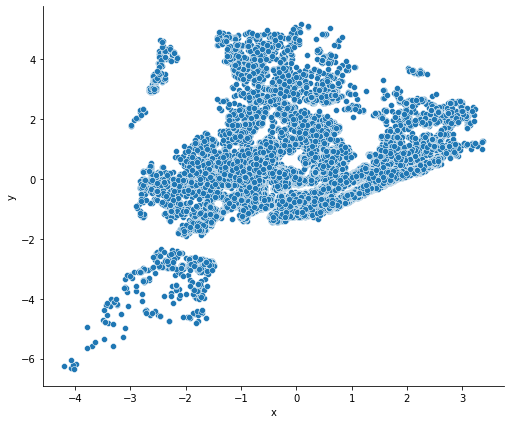

In [37]:
df = pd.DataFrame(dataset[:, 0:2],\
            columns=["x", "y"])
sb.relplot(x='x', y='y', data=df,\
            kind='scatter', height=6, aspect=1.2)

In [4]:
k = 2 # defualt
max_training_epochs = 2000

In [5]:
def init_centroids(X, k):
    return X[\
         np.random.permutation(X.shape[0])[0:k],\
         0:2]

In [6]:
def assign_clusters(X, centroids):
    X_region = tf.slice(X, begin=[0, 0], \
         size=[X.get_shape()[0], 2])
    
    expanded_region = tf.expand_dims(X_region, 0)
    expanded_centroid = tf.expand_dims(centroids, 1)
    
    mse = tf.reduce_mean(tf.square(tf.subtract(\
        expanded_region, expanded_centroid)), 2)
    
    return [tf.reduce_min(mse, 0), tf.argmin(mse, 0)]

# some short demo

# points = tf.constant([[0.,0.], [1.,1.], [2.,2.], [-3.,-3.], [-4.,-4.]])
# centroids = tf.constant([[1., 2.], [-1., -2.]])
# 
# point = tf.expand_dims(points, 0)
# centroids = tf.expand_dims(centroids, 1)
# 
# square_dis = tf.square(tf.subtract(points, centroids))

# print(sess.run(tf.reduce_mean(square_dis, 2)))
# print(sess.run(tf.argmin(tf.reduce_mean(square_dis, 2), 0)))

In [7]:
def recenter_centroids(X, clusters, k):
    # check tensorflow segmentations
    
    # return k number of vectors
    
    X_region = tf.slice(X, begin=[0, 0], \
         size=[X.get_shape()[0], 2])
    sums = tf.unsorted_segment_sum(X_region, clusters, k)
    counts = tf.unsorted_segment_sum(\
        tf.ones_like(X_region), clusters, k)
    
    return tf.divide(sums, counts)

In [8]:
def cal_variance(mse_by_centroid, clusters, k):
    return tf.reduce_sum(tf.unsorted_segment_sum(\
        mse_by_centroid, clusters, k))

In [74]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

accepted_error_dif = 0.0001
X = tf.convert_to_tensor(dataset)

k_history = []
variance_history = []
centroid_history = []
cluster_history = []

for k in range(2, 20):
    centroids = init_centroids(dataset, k)
    variance = np.float32(-1.) # null value
    _clusters = None
    for epoch in range(max_training_epochs):
        [mse_by_centroid, clusters] = assign_clusters(\
            X, tf.convert_to_tensor(centroids))
        var = cal_variance(mse_by_centroid, clusters, k)

        if variance == -1.: variance = sess.run(var)
        elif np.absolute(variance - sess.run(var)) \
                <= accepted_error_dif:
                break   
        else: variance = sess.run(var)
            
        _clusters = sess.run(clusters)

        centroids = sess.run(
            recenter_centroids(X, clusters, k))
        
    cluster_history.append(_clusters)
    centroid_history.append(centroids)
    k_history.append(k)
    variance_history.append(variance)

    print(centroids)

[[ 1.03807255  0.6926872 ]
 [-0.45288175 -0.30219987]]
[[-0.27402216  2.52740795]
 [ 1.09103451 -0.00669422]
 [-0.58215409 -0.2965781 ]]
[[-0.32312709  2.82488936]
 [ 1.30477628  0.30687205]
 [ 0.08373025 -0.83868641]
 [-0.81764379  0.08920437]]
[[-1.32532908 -0.69147667]
 [ 0.20492917 -0.76357351]
 [ 1.38876077  0.29803789]
 [-0.5574114   0.35030113]
 [-0.34285794  2.91579517]]
[[-0.67040368  0.03660837]
 [ 0.21002555 -0.77027083]
 [-0.45224889  3.3013649 ]
 [-0.37161854  1.01132309]
 [-1.51278056 -0.97027617]
 [ 1.42259269  0.26715226]]
[[ 0.143494   -0.75804205]
 [-0.44030807  3.08235507]
 [-2.0854678  -2.76473601]
 [ 1.15342033  0.09168552]
 [ 2.24602834  0.96618137]
 [-0.48537899  0.50680355]
 [-1.15781621 -0.35395672]]
[[-0.3876347   1.07357421]
 [-2.17448369 -3.29718723]
 [-0.50990291  3.34525467]
 [ 2.25837191  0.98017946]
 [ 1.16574683  0.07262794]
 [ 0.17162514 -0.81938832]
 [-1.30528028 -0.48871511]
 [-0.52942278  0.10767714]]
[[-1.29475994 -0.49351743]
 [-2.17399724 -3.2892

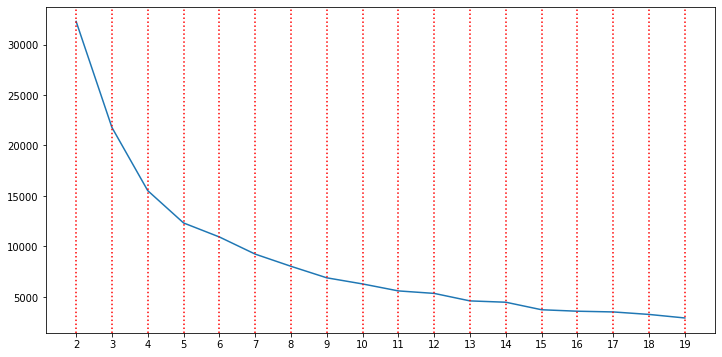

In [112]:
f = plt.figure()
f.set_figheight(6)
f.set_figwidth(12)

plt.plot(k_history, variance_history)
plt.xticks(k_history)

for k in range(2, 20):
    plt.axvline(x=k, color='red', linestyle=':')
plt.show()

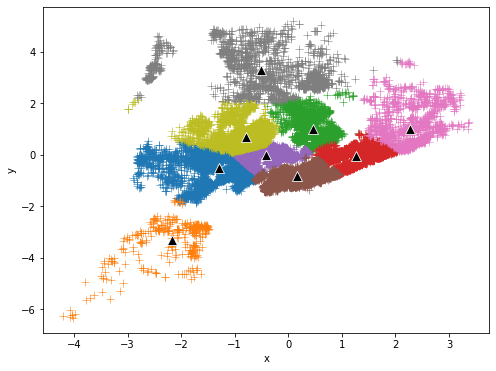

In [177]:
k = 9 # the best k according to elbow

# print(cluster_history[k])

colors = sb.color_palette("Paired", 10)

fig = plt.gcf()
fig.set_size_inches(8, 6)

for k_idx in range(k):
    filter_ids = []
    for i, cluster_id in \
        enumerate(cluster_history[k - 2]):
        
        if int(cluster_id) == k_idx: filter_ids.append(True)
        else: filter_ids.append(False)
    
    x_plot = dataset[filter_ids][:, 0:1]
    y_plot = dataset[filter_ids][:, 1:2]
    
    df = pd.DataFrame(dataset[filter_ids][:, 0:2],\
            columns=["x", "y"])
    sb.scatterplot(data=df, x="x", y="y",\
            marker="+", s=50)


df_centr = pd.DataFrame(centroid_history[k - 2],\
            columns=["x", "y"])
sb.scatterplot(data=df_centr, x="x", y="y",\
    marker="^", color="#000", s=100)

plt.show()